<h1><center> Une application de recommandation de contenu</center></h1>

<hr>
<h3><center>Analyse exploradoire</center></h3>
<br>

>__Réalisé par : Said Arrazouaki__


>__Encadré par : Addi Ait-Mlouk__

## Introduction

Dans ce projet, nous développons une première version du système de recommandation de contenu pour l’application de la start-up My Content, dont l’objectif est d’encourager la lecture en proposant à chaque utilisateur des contenus adaptés à ses préférences. Dans une logique de MVP, nous implémentons deux stratégies de recommandation :

- Le filtrage basé sur le contenu (content-based filtering), qui recommande des articles similaires à ceux que l'utilisateur a déjà consultés en utilisant les métadonnées et des vecteurs d’embedding représentant chaque article.

- Le filtrage collaboratif (collaborative filtering), fondé sur les interactions des utilisateurs (clics) avec les articles, et qui s’appuie sur la factorisation matricielle pour identifier des préférences latentes et proposer des contenus appréciés par des utilisateurs aux comportements similaires.

Pour cette phase d’expérimentation, nous nous appuyons sur un jeu de données riche provenant d’une plateforme d’information. Ce jeu contient plus de 364 000 articles, chacun associé à des métadonnées détaillées et à des vecteurs d’embedding préentraînés qui capturent la similitude sémantique entre articles. Il inclut également des logs d’interactions utilisateurs représentant près de 3 millions de clics collectés sur une période de deux semaines en octobre 2017. Ces données permettent de reconstituer les séquences de lecture des utilisateurs et de mesurer l’intérêt réel pour les différents contenus. Dans ce notebook d’analyse exploratoire, nous décrivons la structure de cet ensemble de données, vérifions la qualité et la distribution des métadonnées, explorons la répartition des clics au fil du temps et parmi les utilisateurs, et examinons les propriétés des embeddings réduits (dimensionnalité, variance expliquée, etc.). Cette exploration fournit des insights précieux sur le comportement des lecteurs et sert de base à la mise en œuvre et à l’évaluation des deux approches de recommandation.

Cette démarche s’inscrit pleinement dans la volonté de My Content de construire une solution scalable, capable à terme d'intégrer facilement l'ajout de nouveaux utilisateurs et de nouveaux articles.

## Importation

In [161]:
# importation des bibliothèques nécessaires
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Chargement des données 

Nous chargeons ici les métadonnées des articles, les embeddings réduits, et les fichiers de clics pour une analyse unifiée.

#### articles_metadata.csv

In [162]:
# Chargement des métadonnées d'articles
articles_df = pd.read_csv('../data/articles_metadata.csv')
print("Nombre d'articles :", len(articles_df))

Nombre d'articles : 364047


#### articles_embeddings.pickle

In [163]:
with open('../data/articles_embeddings.pickle', 'rb') as f:
    articles_emb = pickle.load(f)
print("Taille de la matrice d'embeddings :", articles_emb.shape)

Taille de la matrice d'embeddings : (364047, 250)


#### clicks

In [164]:
# Chargement de tous les fichiers de clics horaires
files = glob.glob('../data/clicks/clicks_hour_*.csv')
clicks_df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
print("Nombre total de clics :", len(clicks_df))

Nombre total de clics : 2988181


In [165]:
# Groupement des clics par utilisateur pour un accès facile
user_clicks = clicks_df.groupby('user_id')['click_article_id'].apply(list).to_dict()

In [166]:
# Enregistrer user_clicks
with open('../data/processed/user_clicks.pickle', 'wb') as f:
    pickle.dump(user_clicks, f)

## Exploration des métadonnées des articles

Dans cette section, nous explorons donc les métadonnées disponibles afin d’identifier les principaux thèmes abordés, de vérifier la présence d’éventuelles valeurs manquantes et de repérer les variables les plus pertinentes pour la personnalisation des contenus.

In [167]:
# Affiche les premières lignes du DataFrame des articles
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [168]:
articles_df.shape

(364047, 5)

In [169]:
articles_df.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [170]:
articles_df.drop(columns=['publisher_id'], inplace=True)  

In [171]:
# le nombre d'article avec 0 words 
articles_df[articles_df['words_count'] == 0].shape[0]

35

Text(0.5, 1.0, "La distribution des catégories d'articles")

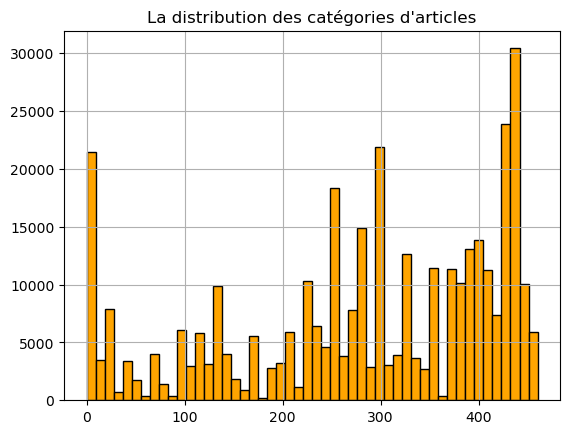

In [172]:
# La distribution des catégories d'articles
articles_df.category_id.hist(bins=50, color='orange', edgecolor='black')
plt.title('La distribution des catégories d\'articles')

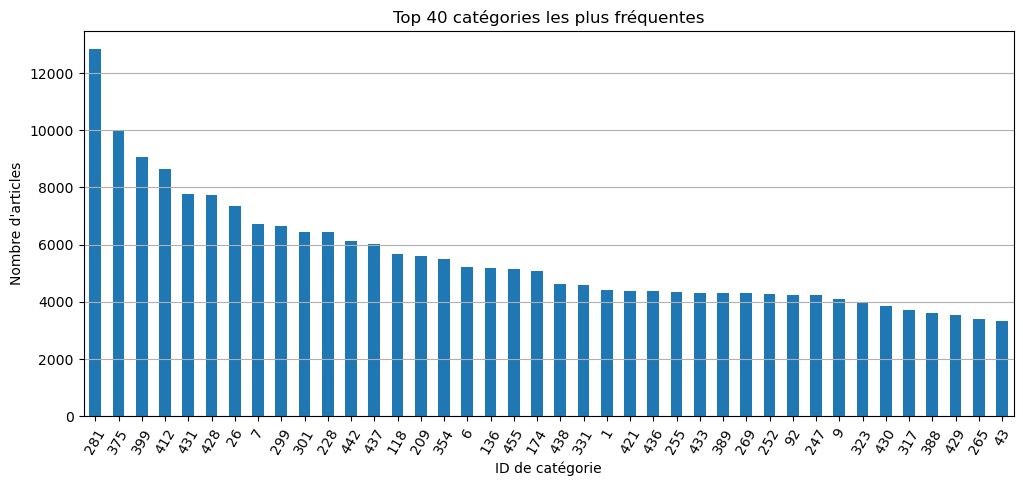

In [173]:
top_n = 40
category_counts = articles_df['category_id'].value_counts().head(top_n)

plt.figure(figsize=(12, 5))
category_counts.plot(kind='bar')
plt.title(f"Top {top_n} catégories les plus fréquentes")
plt.xlabel("ID de catégorie")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

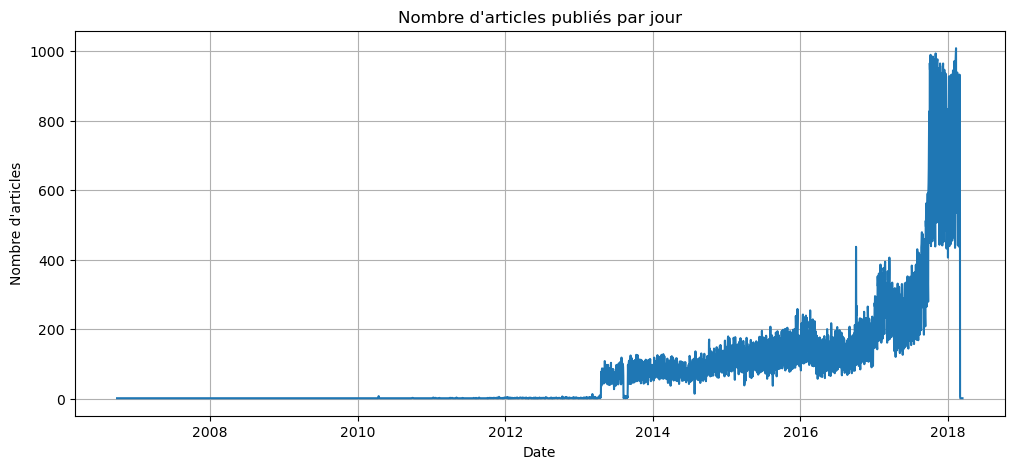

In [174]:
articles_df['created_at'] = pd.to_datetime(articles_df['created_at_ts']//1000, unit='s')
articles_per_day = articles_df['created_at'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
articles_per_day.plot()
plt.title("Nombre d'articles publiés par jour")
plt.xlabel("Date")
plt.ylabel("Nombre d'articles")
plt.grid()
plt.show()

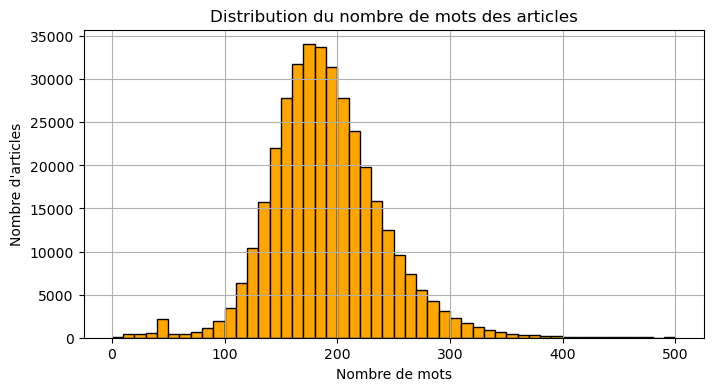

In [175]:
plt.figure(figsize=(8, 4))
plt.hist(articles_df['words_count'], bins=50, color='orange', edgecolor='black', range=(0, 500))
plt.title("Distribution du nombre de mots des articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.grid()
plt.show()

## Analyse des embeddings

Les embeddings constituent la représentation vectorielle des articles dans un espace de dimensions élevées, capturant leurs similarités sémantiques. Dans cette partie, nous examinons leur structure : nombre de vecteurs, taille de chaque embedding, distribution statistique des valeurs et éventuelles anomalies. Nous appliquerons également une technique de réduction de dimension afin de visualiser ces représentations et de vérifier s’il est possible de les compresser sans perte significative d’information, ce qui facilitera l’exploitation dans nos algorithmes de recommandation.

In [176]:
articles_emb.shape

(364047, 250)

In [177]:
articles_emb

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [178]:
# En dataframe
embeddings_df = pd.DataFrame(articles_emb)

In [179]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


#### Distribution des valeurs des embeddings

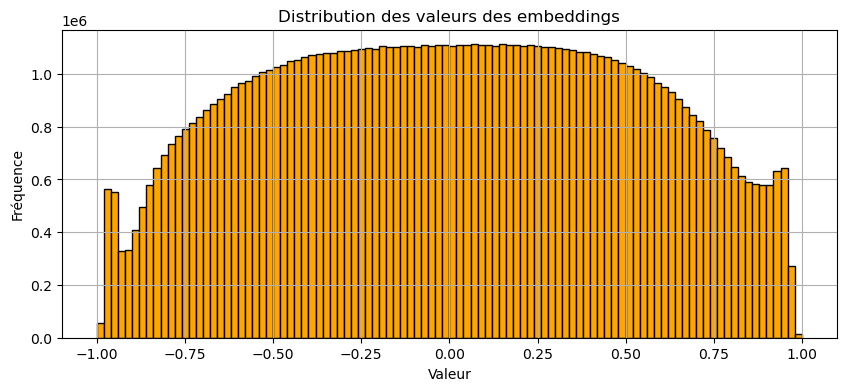

In [180]:
# Distribution des valeurs des embeddings
plt.figure(figsize=(10, 4))
plt.hist(embeddings_df.values.flatten(), bins=100, color='orange', edgecolor='black')
plt.title("Distribution des valeurs des embeddings")
plt.xlabel("Valeur")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

#### Réduction de dimension avec PCA (ACP) pour visualiser les articles

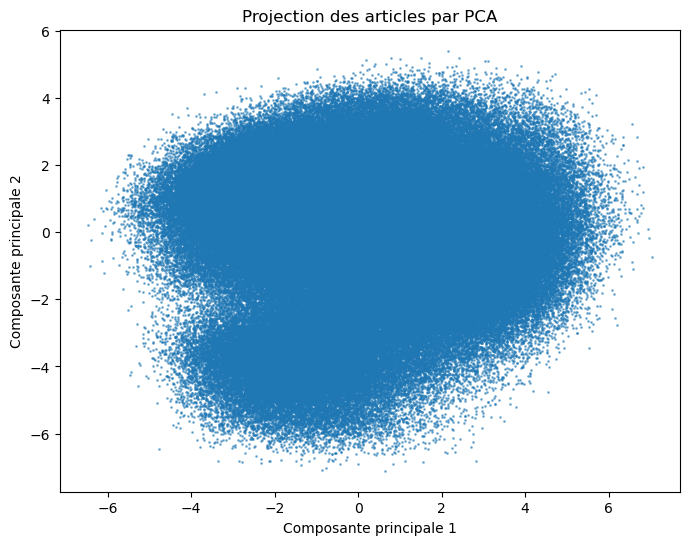

In [181]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_df)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.5)
plt.title("Projection des articles par PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

In [182]:
# PCA
pca_full = PCA().fit(embeddings_df)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Trouver le nombre de composantes pour 98%
n_components_98 = np.argmax(cumulative_variance >= 0.98) + 1

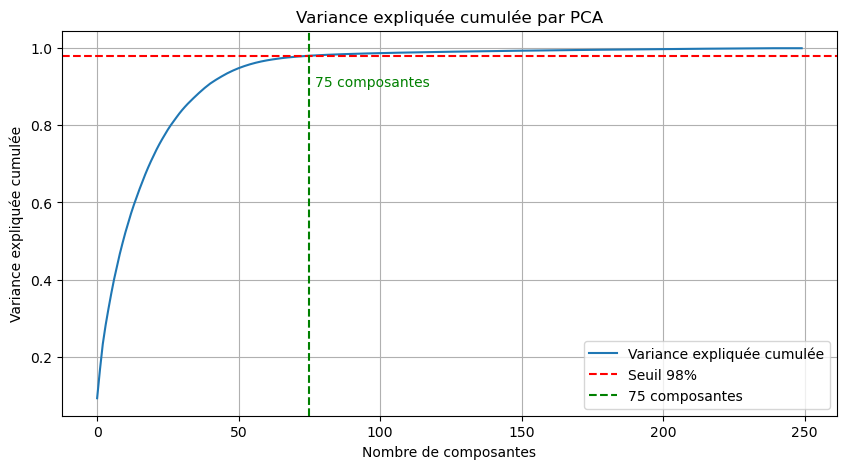

In [183]:
# Affichage
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, label="Variance expliquée cumulée")
plt.axhline(y=0.98, color='red', linestyle='--', label="Seuil 98%")
plt.axvline(x=n_components_98, color='green', linestyle='--', label=f"{n_components_98} composantes")

# Annotation
plt.text(n_components_98 + 2, 0.90, f"{n_components_98} composantes", color='green')

plt.title("Variance expliquée cumulée par PCA")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.legend()
plt.show()

In [184]:
# Nombre de composantes pour capturer 98% de la variance
pca_full = PCA().fit(embeddings_df)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_98 = np.argmax(cumulative_variance >= 0.98) + 1
print(f"Nombre de composantes pour capturer 98% de la variance : {n_components_98}")

Nombre de composantes pour capturer 98% de la variance : 75


In [185]:
# Réduction des dimensions avec n_components_98
pca_reducer = PCA(n_components=n_components_98)
embeddings_reduced = pca_reducer.fit_transform(embeddings_df)

# Convertir en DataFrame (facultatif mais pratique)
embeddings_reduced_df = pd.DataFrame(embeddings_reduced)

embeddings_reduced_df.shape

(364047, 75)

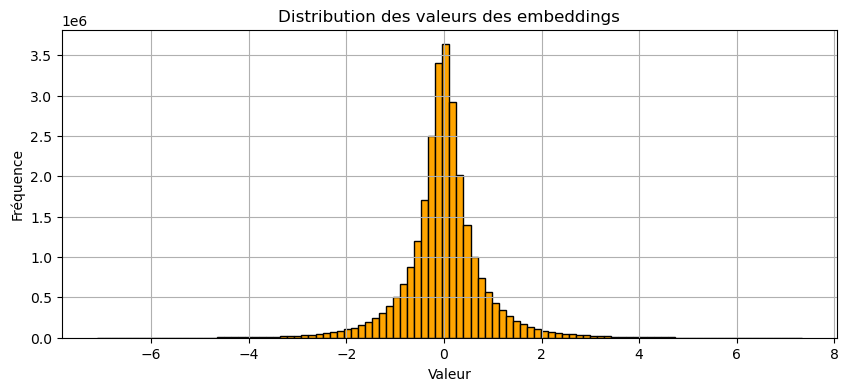

In [186]:
# Distribution des valeurs des embeddings
plt.figure(figsize=(10, 4))
plt.hist(embeddings_reduced_df.values.flatten(), bins=100, color='orange', edgecolor='black')
plt.title("Distribution des valeurs des embeddings")
plt.xlabel("Valeur")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [187]:
# enregistrement des embeddings réduits
embeddings_reduced_df.to_pickle("../data/processed/articles_embeddings_reduced.pickle")

#### Visualisation avec t-SNE

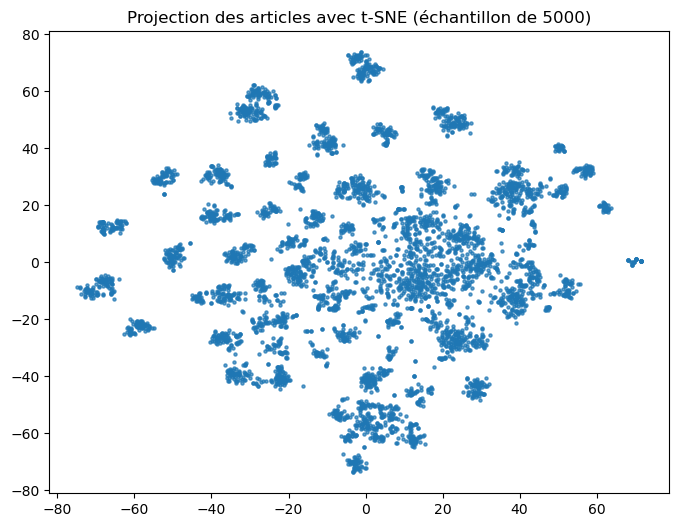

In [188]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df.sample(5000))  # sous-échantillon

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], s=5, alpha=0.7)
plt.title("Projection des articles avec t-SNE (échantillon de 5000)")
plt.show()

## Analyse des logs de clics

Les journaux de clics reflètent les interactions réelles des utilisateurs avec les articles et constituent la base de notre approche de filtrage collaboratif. Dans cette section, nous passons en revue ces logs pour mesurer l’intensité et la répartition des clics : volume total d’événements, période d’observation, fréquence des clics par utilisateur et par article, variations au fil du temps et éventuels comportements atypiques. Cette analyse permettra d’identifier les utilisateurs les plus actifs, de détecter les contenus populaires et de préparer les données pour les algorithmes de recommandation collaborative.

In [189]:
# Dimension
clicks_df.shape

(2988181, 12)

In [190]:
# Affiche les premières lignes du DataFrame des clics
clicks_df.head()  

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [191]:
# Nombre d'utilisateurs
clicks_df.user_id.nunique()

322897

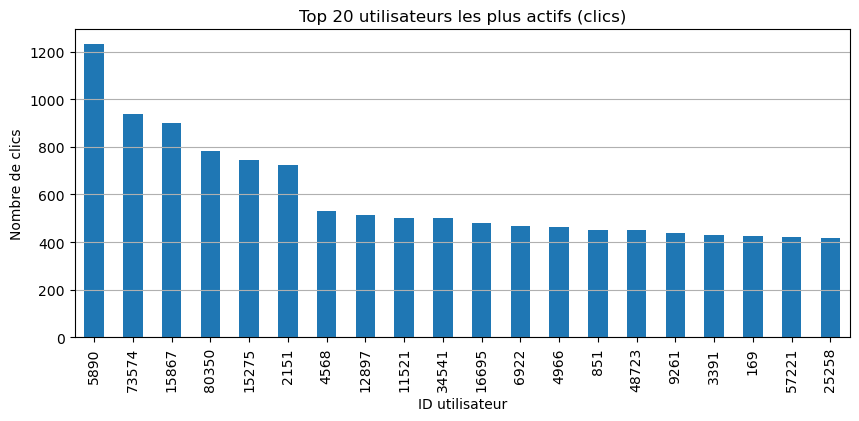

In [192]:
user_clicks = clicks_df['user_id'].value_counts().head(20)

plt.figure(figsize=(10, 4))
user_clicks.plot(kind='bar')
plt.title("Top 20 utilisateurs les plus actifs (clics)")
plt.xlabel("ID utilisateur")
plt.ylabel("Nombre de clics")
plt.grid(axis='y')
plt.show()


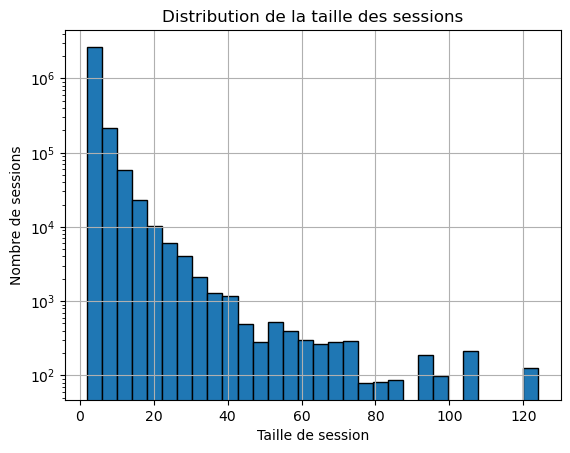

In [198]:
plt.hist(clicks_df['session_size'], bins=30, edgecolor='black', log=True)
plt.title("Distribution de la taille des sessions")
plt.xlabel("Taille de session")
plt.ylabel("Nombre de sessions")
plt.grid()
plt.show()

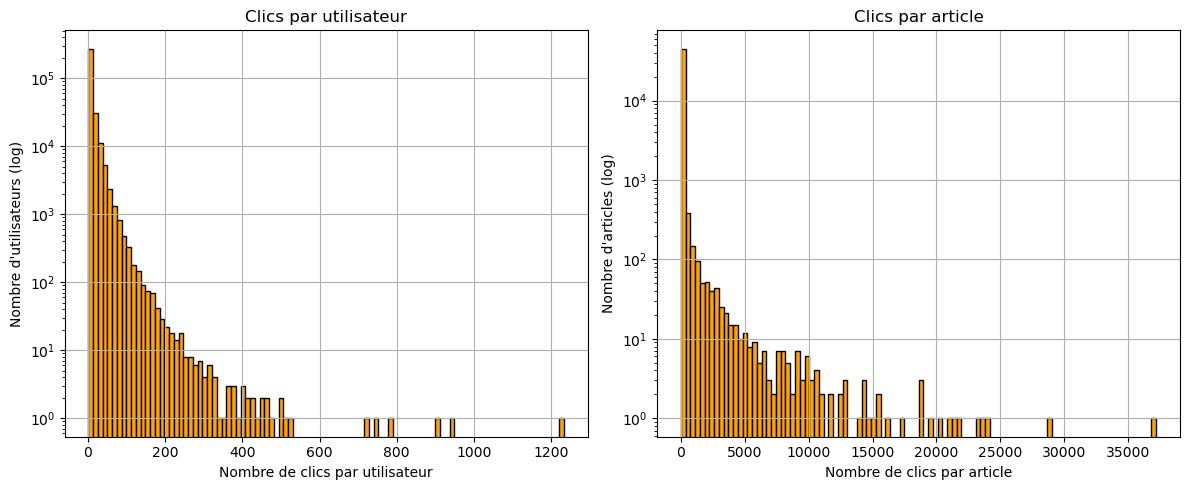

In [196]:
# Compter le nombre de clics par utilisateur et par article
user_click_counts = clicks_df['user_id'].value_counts()
article_click_counts = clicks_df['click_article_id'].value_counts()

# Créer une figure avec deux sous-graphiques côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# Histogramme des clics par utilisateur
ax1.hist(user_click_counts, bins=100, color='orange', edgecolor='black', log=True)
ax1.set_title("Clics par utilisateur")
ax1.set_xlabel("Nombre de clics par utilisateur")
ax1.set_ylabel("Nombre d'utilisateurs (log)")
ax1.grid(True)

# Histogramme des clics par article
ax2.hist(article_click_counts, bins=100, color='orange', edgecolor='black', log=True)
ax2.set_title("Clics par article")
ax2.set_xlabel("Nombre de clics par article")
ax2.set_ylabel("Nombre d'articles (log)")
ax2.grid(True)

# Afficher la figure
plt.show()

## Conclusion

Cette exploration a confirmé l’ampleur et la diversité des données disponibles : plus de 364 000 articles et près de trois millions de clics concentrés sur deux semaines, avec des rythmes de consultation très variables selon les heures et les utilisateurs. La répartition inégale des interactions souligne la nécessité d’un filtrage collaboratif pour capturer des comportements latents et recommander des contenus adaptés.

Nous avons également constaté que les vecteurs d’embedding fournis sont initialement de dimension 250. Une analyse en composantes principales (PCA) a permis de réduire cette dimensionnalité à 75, tout en conservant environ 98 % de la variance, ce qui rend les calculs plus efficaces sans perte significative d’information. Dans l’ensemble, ces constats confirment que les données sont adaptées à la mise en œuvre des deux approches de recommandation envisagées, tout en soulignant l’importance d’un prétraitement soigné et d’une gestion des déséquilibres.